In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
mlp_df = 'mlp_results.csv'
kan_df = 'kan_results.csv'

In [6]:
mlp_df = pd.read_csv(mlp_df)
kan_df = pd.read_csv(kan_df)

In [9]:
print(mlp_df.columns)
mlp_df.head()

Index(['epoch', ' train_acc', ' test_acc', ' time'], dtype='object')


,epoch,train_acc,test_acc,time
0,0,0.904247,0.910256,25.75
1,2,0.933443,0.934195,38.61
2,4,0.940087,0.940004,38.58
3,6,0.943960,0.948618,38.14
4,8,0.946247,0.947015,37.17


Text(0.5, 1.0, 'MNIST Training Time using HSIC Bottleneck Training')

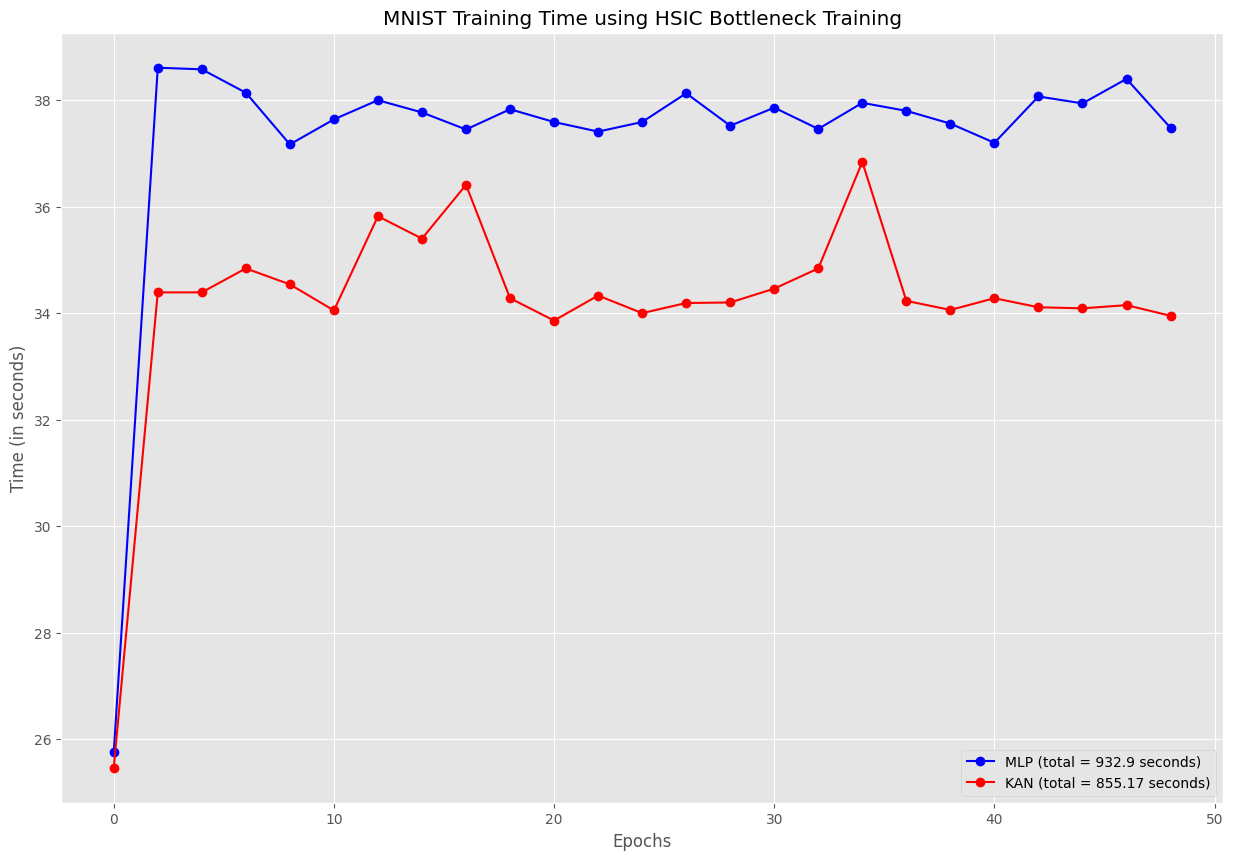

In [38]:
import numpy as np

plt.style.use('ggplot')
plt.subplots(figsize = (15,10))
epochs = mlp_df['epoch']
total_mlp = np.sum(mlp_df[' time']).round(2)
total_kan = np.sum(kan_df[' time']).round(2)

plt.plot(epochs, mlp_df[' time'], color = 'blue', label = 'MLP (total = ' + str(total_mlp) + " seconds)", marker = 'o')
plt.plot(epochs, kan_df[' time'], color = 'red', label = 'KAN (total = ' + str(total_kan) + " seconds)", marker = 'o')

plt.xlabel("Epochs")
plt.ylabel("Time (in seconds)")
plt.legend()
plt.title("MNIST Training Time using HSIC Bottleneck Training")

In [4]:
import pandas as pd
import numpy as np
import os
print(os.getcwd())
RESULTS_FOLDER = '../Results/'
result_files = [os.path.join(RESULTS_FOLDER, x) for x in os.listdir(RESULTS_FOLDER) if x.endswith('.csv') and 'optimizer' in x]
result_rows = []
for r in result_files:
    
    filename = os.path.split(r)[-1]
    #print("Processing: ", filename)

    # Extract relevent information from filename
    params = filename.replace(".csv", "").split("_")
    dataset = params[0]
    backprop = params[1]
    model = params[2]
    num_layers = params[3]
    batchsize = int(params[5])
    lr = float(params[7])
    epochs = int(params[9])
    num_parameters = int(params[11])
    optimizer = params[13]
    init = '_'.join(params[15:17]) if len(params) > 14 else "kaiming_uniform"
    #print(init, "----------------")
    # Get best test performance and when it was reached
    try:
        data = pd.read_csv(r)
    except FileNotFoundError:
        print("Could not read: ", r)
        continue
    best_perf_test =  np.max(data['Test_loss'])
    best_perf_train = np.max(data['Train_loss'])
    best_perf_epoch_test = np.where(data['Test_loss'] == best_perf_test)[0][0]
    epochs = np.max(data['Epoch'])

    generalization = data['Train_loss'] - data['Test_loss']
    avg_gen = np.mean(generalization)
    # Get the average time taken per epoch
    avg_time = np.mean(data['Time'])

    result_rows.append([dataset, backprop, model, num_layers, batchsize, lr, epochs, num_parameters, 
                       optimizer, best_perf_train, best_perf_test, best_perf_epoch_test, avg_time, init, avg_gen])


df = pd.DataFrame(result_rows)
df.columns = ["Dataset", "Backprop", "Model", "Num_layers", "Batchsize", "LearningRate", "TotalEpochs", "Num_parameters",
              "Optimizer", "Best_train", "Best_test", "Best_test_at", "Avg_time", "Initialization", "AvgGenError"]

print(df.head())


C:\Users\shairozs\Documents\Projects\HSIC_Bottleneck-Pytorch\Notebooks
Could not read:  ../Results/MNIST_backprop_mlpWideWideWideWideWideWideWideWideWideWideWideWideWideWideWideWideWide_4layers_batchsize_4096_lr_0.0005_epochs_100_parameters_255050_optimizer_Adam_init_kaiming_normal_.csv
Could not read:  ../Results/MNIST_backprop_mlpWideWideWideWideWideWideWideWideWideWideWideWideWideWideWideWide_4layers_batchsize_4096_lr_0.0005_epochs_100_parameters_255050_optimizer_SGDM_init_kaiming_normal_.csv
Could not read:  ../Results/MNIST_backprop_mlpWideWideWideWideWideWideWideWideWideWideWideWideWideWideWide_4layers_batchsize_4096_lr_0.005_epochs_100_parameters_255050_optimizer_SGD_init_kaiming_normal_.csv
  Dataset  Backprop Model Num_layers  Batchsize  LearningRate  TotalEpochs  \
0   CIFAR  backprop   kan    2layers       2048        0.0005           98   
1   CIFAR  backprop   kan    2layers       2048        0.0005           98   
2   CIFAR  backprop   kan    2layers       2048        0.0

In [5]:
df = df[df.Model.apply(lambda x: len(x)) <= 9]
df['Optimizer'] = pd.Series([x.rstrip() for x in df.Optimizer])
#df['Model'] = df['Model'].apply(lambda x: x[:7])

df['ModelType'] = df['Model'] + "_" + df['Num_layers']

## Populate Intrinsic Dimension
conditions = [
    (df['Dataset']=='MNIST'),
    (df['Dataset'] == 'CIFAR')]
choices = [750, 9000]
df['ID'] = np.select(conditions, choices)

df['Efficiency'] = (df['Best_test'] / (df['Best_test_at'] + 1))*(1/np.log( 1 + df['Num_parameters'] - df['ID']))
df = df[(df.TotalEpochs > 90)]# & (df.Dataset == 'MNIST')]#print(df.TotalEpochs> 90)
#df = df[df.TotalEpochs == 100]
#df.sort_values('Best_test')
df.sort_values('Efficiency')

,Dataset,Backprop,Model,Num_layers,Batchsize,LearningRate,TotalEpochs,Num_parameters,Optimizer,Best_train,Best_test,Best_test_at,Avg_time,Initialization,AvgGenError,ModelType,ID,Efficiency
15,CIFAR,backprop,kan,2layers,2048,0.0050,98,7890452,SGD,0.948425,0.490479,49,28.912316,kaiming_normal,0.455302,kan_2layers,9000,0.000618
3,CIFAR,backprop,kan,2layers,2048,0.0005,98,7890452,SGDM,0.952616,0.491943,49,29.197826,kaiming_normal,0.459825,kan_2layers,9000,0.000620
31,CIFAR,backprop,kan,3layers,2048,0.0050,98,17066516,Adam,0.999186,0.530884,49,23.179693,kaiming_uniform,0.348932,kan_3layers,9000,0.000638
35,CIFAR,backprop,kan,3layers,2048,0.0050,98,17066516,SGDM,0.689941,0.536987,49,22.692246,orthogonal_,0.062211,kan_3layers,9000,0.000645
54,CIFAR,backprop,kan,4layers,2048,0.0050,98,38040084,SGD,0.995361,0.526855,45,24.508561,kaiming_normal,0.469979,kan_4layers,9000,0.000656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,MNIST,backprop,kan,2layers,4096,0.0050,98,254080,Adam,0.998954,0.952148,0,8.438961,kaiming_uniform,0.048938,kan_2layers,750,0.076524
259,Fashion,backprop,mlp,3layers,4096,0.0005,98,52842,Adam,0.984113,0.881348,0,9.382517,orthogonal_,0.101084,mlp_3layers,0,0.081043
527,MNIST,backprop,mlp,4layers,4096,0.0050,98,111594,SGD,1.000000,0.975830,0,7.497591,kaiming_normal,0.024630,mlp_4layers,750,0.084008
477,MNIST,backprop,mlp,3layers,4096,0.0005,98,52842,Adam,0.999983,0.973877,0,7.506084,kaiming_normal,0.026750,mlp_3layers,750,0.089669


In [198]:
print(df.Model.unique())

['kan' 'mlpWide' 'mlp']


In [199]:
df['ModelType'].unique()

array(['kan_2layers', 'kan_3layers', 'kan_4layers', 'mlpWide_2layers',
       'mlpWide_3layers', 'mlpWide_4layers', 'mlp_2layers', 'mlp_3layers',
       'mlp_4layers'], dtype=object)

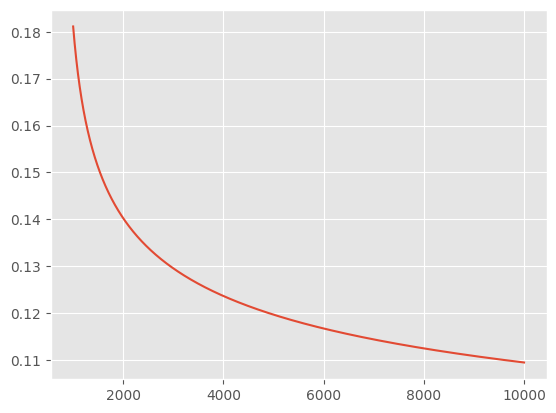

In [200]:
ax = [x for x in range(1000, 10000)]
ay = [1 / np.log(x - 750) for x in ax]
plt.plot(ax, ay)

In [6]:
df.to_csv('results_compiled.csv')

Text(0.5, 1.0, 'Test Acc under Backprop Training Schemes')

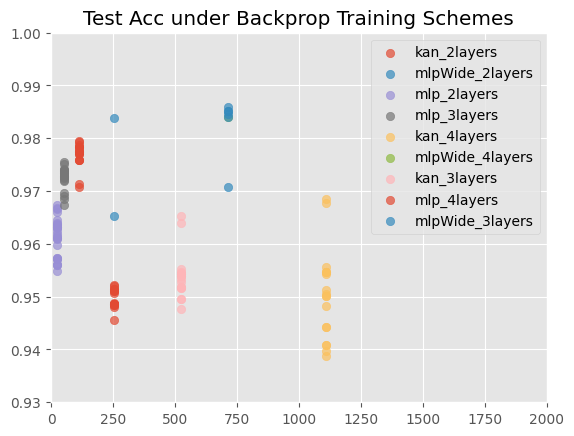

In [202]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for model in set(np.unique(df['ModelType'])):
    sa = df[(df.ModelType ==model)]
    plt.scatter(sa.Num_parameters/1000, sa.Best_test, marker = 'o', label = model, alpha = 0.7)#, s =10)
plt.ylim(0.93, 1)
plt.xlim(-2, 2000)
plt.legend()
plt.title("Test Acc under Backprop Training Schemes")
#for i in set(sa.Num_layers):
#    print(i)
#    plt.plot(sa[sa.Num_layers==i].Best_test, label = i)
#sa = sa[sa.Optimizer == 'AdamW']
#sa = sa[sa.LearningRate == 

In [148]:
df.Dataset.unique()

array(['CIFAR', 'Fashion', 'MNIST'], dtype=object)

Text(0.5, 1.0, 'Avg. Epoch Time under Backprop Training Schemes')

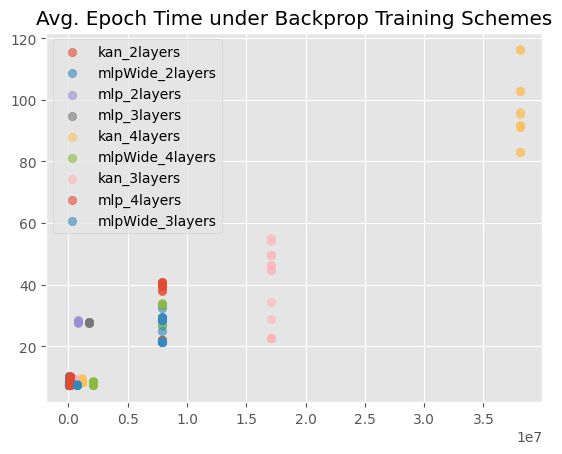

In [149]:
import matplotlib.pyplot as plt
for model in set(np.unique(df['ModelType'])):
    sa = df[(df.ModelType ==model)]
    plt.scatter(sa.Num_parameters, sa.Avg_time, marker = 'o', label = model, alpha = 0.6)
plt.legend()
plt.title("Avg. Epoch Time under Backprop Training Schemes")

Text(0.5, 1.0, 'Parameters vs Efficiency under Backprop Training Schemes')

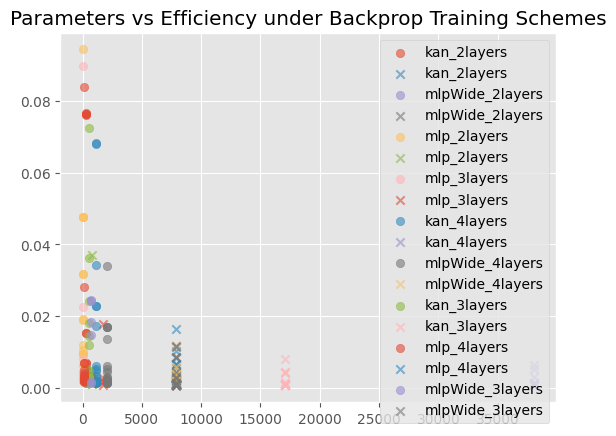

In [150]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
for model in set(np.unique(df['ModelType'])):
    sa = df[(df.ModelType ==model)]
    for dataset in ['MNIST', 'CIFAR']:
        mark = 'o' if dataset=='MNIST' else 'x'
        g = sa[sa.Dataset == dataset]
        axes.scatter(g.Num_parameters/1000, g.Efficiency, marker = mark, label = model, alpha = 0.6)
plt.legend()
plt.title("Parameters vs Efficiency under Backprop Training Schemes")

Text(0.5, 1.0, 'Best Test Acc Under All Training Schemes')

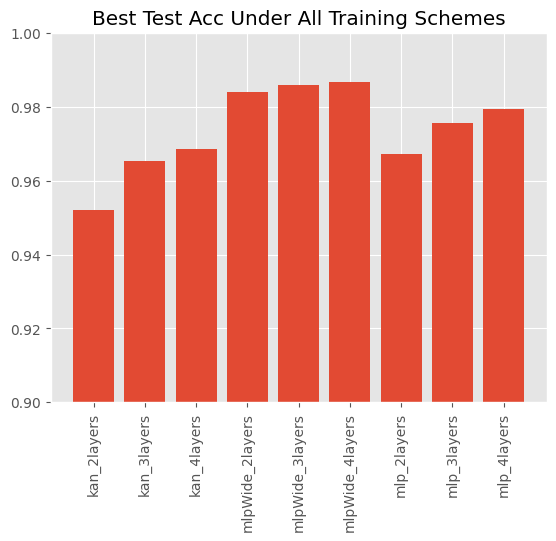

In [174]:
zs = df.groupby("ModelType", group_keys=True)[['Best_test']].max()
plt.bar(zs.index, zs.Best_test); plt.ylim(0.9,1)
plt.xticks(rotation = 90)
plt.title("Best Test Acc Under All Training Schemes")

Text(0.5, 1.0, 'Best Test Acc Under All Training Schemes')

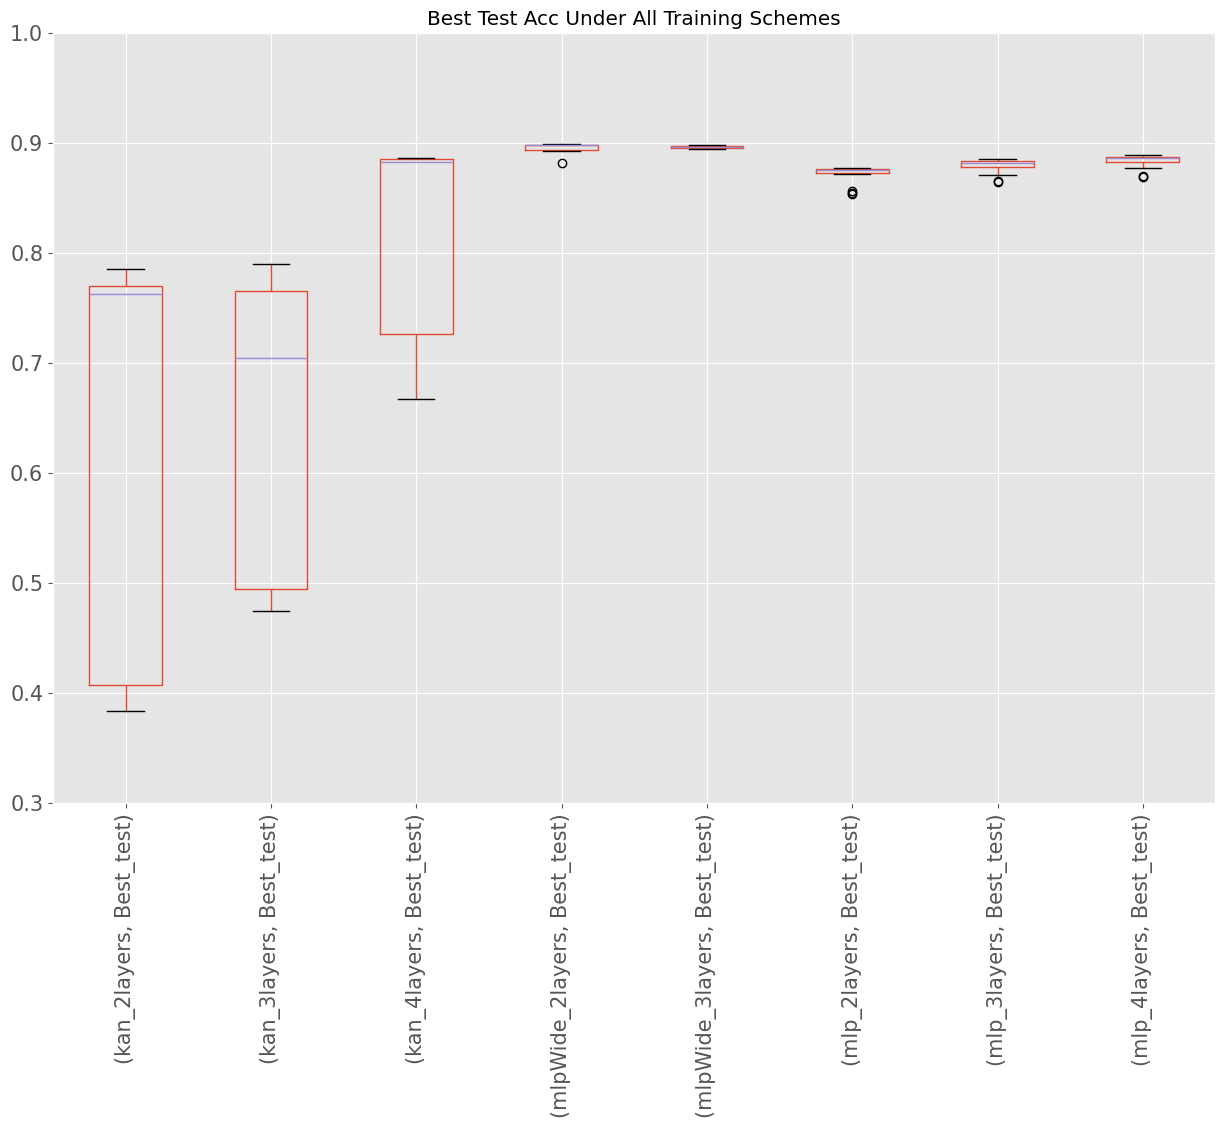

In [177]:
zs = df[df.Dataset == 'Fashion']
zs = zs.groupby("ModelType", group_keys=True)[['Best_test']]

zs.boxplot(figsize = (15,10), fontsize = 15,  subplots = 0)
plt.xticks(rotation = 90)
plt.ylim(0.30, 1)
plt.title("Best Test Acc Under All Training Schemes")
#plt.ylim(0.45, 0.6)
#plt.box(zs.index, zs.Best_test); plt.ylim(0.75,1)


Text(0.5, 1.0, 'Best Test Acc Under All Training Schemes')

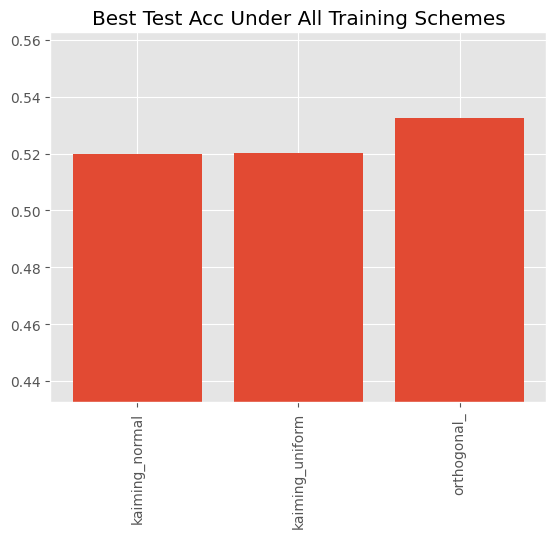

In [184]:
grouper = 'Initialization'
response = 'Best_test'
#zs = df.groupby("Optimizer", group_keys=True)[['Best_test', 'ModelType']]
zs = df[df.Dataset == 'CIFAR']
zs = zs[['kan' in c for c in list(zs['ModelType'])]][[grouper,response]]
zs = zs.groupby(grouper, group_keys=True)[[response]].median()
plt.bar(zs.index, zs.Best_test); 
m = np.max(zs.Best_test); plt.ylim(m - .1,m + 0.03)
plt.xticks(rotation = 90)
plt.title("Best Test Acc Under All Training Schemes")
#plt.bar(zs.index, zs.Best_test); plt.ylim(0.75,1)
#plt.xticks(rotation = 90)
#plt.title("Best Test Acc Under All Training Schemes")

In [133]:
df.Dataset.unique()

array(['CIFAR', 'Fashion', 'MNIST'], dtype=object)